<a href="https://colab.research.google.com/github/nambeuch/image-spam-catcher/blob/main/modele_3_Projet_synthese.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Modèle 3 - Réseau de neurones convolutifs
# par Christian Nambeu
# Août 2023
# Projet Synthèse: Classification automatisée d'images-pourriels
# Utilisation d'Autokeras pour dériver un modèle de neurones convolutifs

In [ ]:
!pip install autokeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.6/148.6 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 573.5/573.5 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.1/880.1 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 32.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 14.8 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.7.1
    Uninstalling typing_extensions-4.7.1:
      Successfully uninstalled typing_extensions-4.7.1
  Attempting uninstall: tensorflow-estimator
    Found existing installation: ten

In [ ]:
# importer les librairies utiles
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist

import autokeras as ak
import os
from pathlib import Path

Using TensorFlow backend


In [ ]:
# trouver l'emplacement par défaut
print(os.getcwd())

/content


In [ ]:
# voir le contenu du répertoire de travail
!ls /content

sample_data


In [ ]:
root = Path("/root/.keras/datasets/")

In [ ]:
# télécharger les données sur disque - dans mon cas sous le répertoire /root/  ... dans gcollab

# télécharger SPAM
import pathlib
dataset_url = "https://www.cs.jhu.edu/~mdredze/datasets/image_spam/personal_image_spam.tar.gz"
tf.keras.utils.get_file(origin=dataset_url, extract=True) # les fichier sont stockés dans le répertoire /.keras/datasets par défaut

29793833/29793833 [==============================] - 1s 0us/step


'/root/.keras/datasets/personal_image_spam.tar.gz'

In [ ]:
!ls /root/.keras/datasets/

personal_image_spam  personal_image_spam.tar.gz


In [ ]:
# télécharger HAM
dataset_url = "https://www.cs.jhu.edu/~mdredze/datasets/image_spam/personal_image_ham.tar.gz"
tf.keras.utils.get_file(origin=dataset_url, extract=True)
#data_dir = pathlib.Path(data_dir).with_suffix('')

112047863/112047863 [==============================] - 10s 0us/step


'/root/.keras/datasets/personal_image_ham.tar.gz'

In [ ]:
# creer une dossier et copier les deux répertoires dedans
!mkdir /root/.keras/datasets/data_image
# déplacer le dossier de-zipper personal_image_ham dans le répertoire daa_image
!mv /root/.keras/datasets/personal_image_ham/ /root/.keras/datasets/data_image
# faire de même pour le dossier personal_image_spam
!mv /root/.keras/datasets/personal_image_spam/ /root/.keras/datasets/data_image

In [ ]:
# supprimer les dossiers zippés pour faire de l'espace.
!rm -r /root/.keras/datasets/personal_image_spam.tar.gz
!rm -r /root/.keras/datasets/personal_image_ham.tar.gz

In [ ]:
# voir ce qui reste le répertoire datasets de /.keras/datasets
!ls /root/.keras/datasets/

data_image


In [ ]:
num_skipped = 0
# ce bout de code loop sur l'ensemble des images. Les images qui ne sont pas compatibles au format JFIF sont supprimées.
# le format JFIF est un standard qui s'applique aux images avec une extension JPEG

for folder_name in ("personal_image_ham", "personal_image_spam"):
    folder_path = os.path.join(root,"data_image", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 3992 images


In [ ]:
# dimensions de l'image et le nombre de lots
image_size = (180, 180)
batch_size = 64

In [ ]:
# sélection de l'ensemble d'apprentissage
train_ds = ak.image_dataset_from_directory(
    "/root/.keras/datasets/data_image",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 1281 files belonging to 2 classes.
Using 1025 files for training.


In [ ]:
# sélection de l'ensemble test/validation
val_ds = ak.image_dataset_from_directory(
    "/root/.keras/datasets/data_image",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 1281 files belonging to 2 classes.
Using 256 files for validation.


In [ ]:
#  initialisation du classificateur d'images
clf = ak.ImageClassifier(overwrite=True, max_trials=1, project_name= "Image-Spam")

In [ ]:
# ajuster le classificateur avec les échantillons d'apprentissage
clf.fit(train_ds, epochs=5)

Trial 1 Complete [00h 15m 14s]
val_loss: 0.13127247989177704

Best val_loss So Far: 0.13127247989177704
Total elapsed time: 00h 15m 14s
Epoch 1/5
17/17 [==============================] - 173s 10s/step - loss: 1.3175 - accuracy: 0.8800
Epoch 2/5
17/17 [==============================] - 162s 9s/step - loss: 0.1601 - accuracy: 0.9512
Epoch 3/5
17/17 [==============================] - 165s 10s/step - loss: 0.0855 - accuracy: 0.9727
Epoch 4/5
17/17 [==============================] - 165s 10s/step - loss: 0.0400 - accuracy: 0.9863
Epoch 5/5
17/17 [==============================] - 176s 10s/step - loss: 0.0155 - accuracy: 0.9941


In [ ]:
# prédiction avec le meilleur modèle
predicted_y = clf.predict(val_ds)
print(predicted_y)

4/4 [==============================] - 10s 2s/step
[['personal_image_ham']
 ['personal_image_ham']
 ['personal_image_ham']
 ['personal_image_ham']
 ['personal_image_ham']
 ['personal_image_ham']
 ['personal_image_ham']
 ['personal_image_ham']
 ['personal_image_ham']
 ['personal_image_ham']
 ['personal_image_ham']
 ['personal_image_spam']
 ['personal_image_ham']
 ['personal_image_ham']
 ['personal_image_ham']
 ['personal_image_ham']
 ['personal_image_ham']
 ['personal_image_ham']
 ['personal_image_ham']
 ['personal_image_ham']
 ['personal_image_ham']
 ['personal_image_ham']
 ['personal_image_ham']
 ['personal_image_ham']
 ['personal_image_ham']
 ['personal_image_ham']
 ['personal_image_ham']
 ['personal_image_ham']
 ['personal_image_ham']
 ['personal_image_ham']
 ['personal_image_ham']
 ['personal_image_spam']
 ['personal_image_spam']
 ['personal_image_ham']
 ['personal_image_ham']
 ['personal_image_ham']
 ['personal_image_ham']
 ['personal_image_ham']
 ['personal_image_spam']
 ['person

In [ ]:
# Évaluation du meilleur modèle - Les différentes métriques sont calculées.
print(clf.evaluate(val_ds))

4/4 [==============================] - 14s 3s/step - loss: 0.0103 - accuracy: 0.9961
[0.010303480550646782, 0.99609375]


In [ ]:
# exporter le modèle
model = clf.export_model()

Utilisation du modèle

In [ ]:
# les images se trouvent dans /root/.keras/datasets/personal_image_ham et ----/--spam
import random
def load_randomly_image(folder_path, image_size):
  file_paths = []
  if os.path.exists(folder_path) and os.path.isdir(folder_path):
        for root, dirs, files in os.walk(folder_path):
            for file in files:
                file_paths.append(os.path.join(root, file))
  else:
        print("Folder path does not exist or is not a directory.")

  list_length = len(file_paths)
  random_num = random.randint(1, list_length)
  a = file_paths[random_num]
  pick_path = os.path.join(a)
  # get the names of all the files in the folder
  img = tf.keras.utils.load_img(
    pick_path, target_size=image_size
  )
  return img

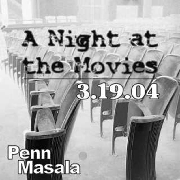

In [ ]:
load_randomly_image("/root/.keras/datasets/data_image/personal_image_ham", image_size = image_size)

In [ ]:
img_ham = load_randomly_image("/root/.keras/datasets/data_image/personal_image_ham", image_size = image_size)
img_spam = load_randomly_image("/root/.keras/datasets/data_image/personal_image_spam", image_size = image_size)

In [ ]:
# convertir l'image en array - HAM
img_array = tf.keras.utils.img_to_array(img_ham)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

In [ ]:
#faire des prédictions avec le meilleur modèle pour un HAM
print("Vraie valeur HAM")
predictions = model.predict(img_array)
probability = float(predictions[0])
print(f"This image is {100 * (1 - probability):.2f}% ham and {100 * probability:.2f}% spam.")

Vraie valeur HAM
1/1 [==============================] - 0s 229ms/step
This image is 99.96% ham and 0.04% spam.


In [ ]:
# convertir l'image en array - spam
img_array = tf.keras.utils.img_to_array(img_spam)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

In [ ]:
print("Vraie valeur SPAM")
predictions = model.predict(img_array)
score = float(predictions[0])
print(f"This image is {100 * (1 - score):.2f}% ham and {100 * score:.2f}% spam.")

Vraie valeur SPAM
1/1 [==============================] - 0s 114ms/step
This image is 2.05% ham and 97.95% spam.


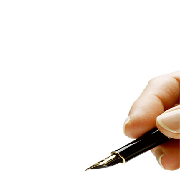

In [ ]:
img_spam

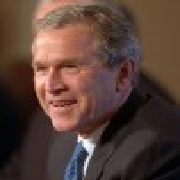

In [ ]:
img_ham

Résumé du modèle obtenu

In [ ]:
# sauvegarde du meilleur modèle
model.save("model_autokeras", save_format = "tf")

In [ ]:
# tester si le modèle sauvegardé peut être utilisé
from tensorflow.keras.models import load_model

In [ ]:
def getPrediction(image):
  # load le modèle
  loaded_model = load_model("model_autokeras", custom_objects=ak.CUSTOM_OBJECTS) # on télécharge avec les objets customisés
  # convertit les features en array
  img_array = tf.keras.utils.img_to_array(image)
  img_array = tf.expand_dims(img_array, 0)  # Create batch axis

  predictions = model.predict(img_array) # obtient la probabilité spam
  probability = float(predictions[0])
  print(f"This image is {100 * (1 - probability):.2f}% ham and {100 * probability:.2f}% spam.")
  return (probability > 0.5, probability)

In [ ]:
result = getPrediction(img_spam)

1/1 [==============================] - 0s 76ms/step
This image is 2.05% ham and 97.95% spam.


In [ ]:
print(result)

(True, 0.9795439839363098)


In [ ]:
# Architecture du modèle
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 cast_to_float32 (CastToFlo  (None, 180, 180, 3)       0         
 at32)                                                           
                                                                 
 normalization (Normalizati  (None, 180, 180, 3)       7         
 on)                                                             
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 176, 176, 64)      18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 88, 88, 64)        0     

In [ ]:
# sauvegarder le modèle localement pour le déploiement sur le web.
# noter que le modèle est enregistré dans un dossier non-zippé - et pas facile de le copier localement facilement
# je vais le zipper et ensuite le copier sur ma machine localement et ensuite préparer les fichiers pour Keroku.

from google.colab import files

!zip -r /content/model_autokeras.zip /content/model_autokeras/

updating: content/model_autokeras/ (stored 0%)
  adding: content/model_autokeras/assets/ (stored 0%)
  adding: content/model_autokeras/fingerprint.pb (stored 0%)
  adding: content/model_autokeras/keras_metadata.pb (deflated 89%)
  adding: content/model_autokeras/saved_model.pb (deflated 86%)
  adding: content/model_autokeras/variables/ (stored 0%)
  adding: content/model_autokeras/variables/variables.index (deflated 55%)
  adding: content/model_autokeras/variables/variables.data-00000-of-00001 (deflated 8%)


In [ ]:
files.download("model_autokeras.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Commentaires**


*   Utiliser un plus grand ensemble de données
*   Utiliser un plus grand nombre d'essais avec autokeras
*   Produire F1-score. Indication que les classes sont déséquilibrées?

